In [1]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math, string

In [2]:
drugbank_df = pd.read_csv("data_processed/drugbank_processed_combos_syntoxtargallpw_string.csv")
ddinter_df = pd.read_csv("data_processed/ddinter_processed_combos_syntoxtargallpw_string.csv")

with open('results/summary_stats_database/drugbank_summary_stats.json', 'r') as f:
    drugbank_summary = json.load(f)

with open('results/summary_stats_database/ddinter_summary_stats.json', 'r') as f:
    ddinter_summary = json.load(f)

combined_df = pd.DataFrame({
    'Metric': drugbank_summary.keys(),
    'DrugBank': drugbank_summary.values(),
    'DDInter': [ddinter_summary[k] for k in drugbank_summary.keys()]
})

In [3]:
import pandas as pd
import numpy as np
import os
import re

# --- rows to show
rows_to_keep = [
    'Total Entries',
    'Major Toxicity Entries',
    'Moderate Toxicity Entries',
    'Minor Toxicity Entries',
    'Unique Drugs',
    'Unique Major Toxicity Pairs',
    'Unique Moderate Toxicity Pairs',
    'Unique Minor Toxicity Pairs',
    'Number of Cell Lines'
]

# 0) Helper: extract leading number from either numeric or string cells
def extract_number(s):
    if pd.isna(s):
        return np.nan
    # already numeric
    if isinstance(s, (int, float, np.integer, np.floating)):
        return float(s)
    # string -> take the first numeric token (handles "36864 (58.8%)", "123.0 ± 4.5", etc.)
    m = re.search(r'[+-]?\d+(?:\.\d+)?', str(s))
    return float(m.group(0)) if m else np.nan

# 1) Build a clean NUMERIC copy of the value columns, regardless of prior formatting
raw = combined_df.copy()
for col in ['DrugBank', 'DDInter']:
    raw[col] = combined_df[col].apply(extract_number)

# 2) Filter the numeric copy
overview_stats = raw[raw['Metric'].isin(rows_to_keep)].copy()

# 3) Denominators for percentages (one per database)
if 'Total Entries' in overview_stats['Metric'].values:
    totals = (overview_stats
              .set_index('Metric')
              .loc['Total Entries', ['DrugBank', 'DDInter']])
else:
    # fallback if the row is missing; you can set these from your source dfs
    totals = pd.Series({'DrugBank': np.nan, 'DDInter': np.nan})

tox_rows = {'Major Toxicity Entries', 'Moderate Toxicity Entries', 'Minor Toxicity Entries'}

def fmt_cell(val, metric, col):
    if pd.isna(val):
        return ""
    if metric in tox_rows and pd.notna(totals[col]) and totals[col] > 0:
        pct = (val / totals[col]) * 100.0
        return f"{int(round(val))} ({pct:.1f}%)"
    # non-tox rows: integer if integral, else 4 d.p.
    v = float(val)
    return f"{int(round(v))}" if v.is_integer() else f"{v:.4f}"

# 4) String-formatted copy for LaTeX
overview_fmt = overview_stats.copy()
for col in ['DrugBank', 'DDInter']:
    overview_fmt[col] = [
        fmt_cell(overview_stats.loc[i, col], overview_stats.loc[i, 'Metric'], col)
        for i in overview_stats.index
    ]

# 5) Export (centered)
latex_table = overview_fmt.to_latex(
    index=False,
    caption="Comparison of summary statistics between DrugBank and DDInter datasets",
    label="tab:drugbank_ddinter_summary",
    column_format="lcc",
    escape=True
).replace("\\begin{table}", "\\begin{table}\n\\centering")

os.makedirs("results/summary_stats_database", exist_ok=True)
with open("results/summary_stats_database/combined_summary_table.tex", "w") as f:
    f.write(latex_table)

print("Wrote: results/summary_stats_database/combined_summary_table.tex")

Wrote: results/summary_stats_database/combined_summary_table.tex


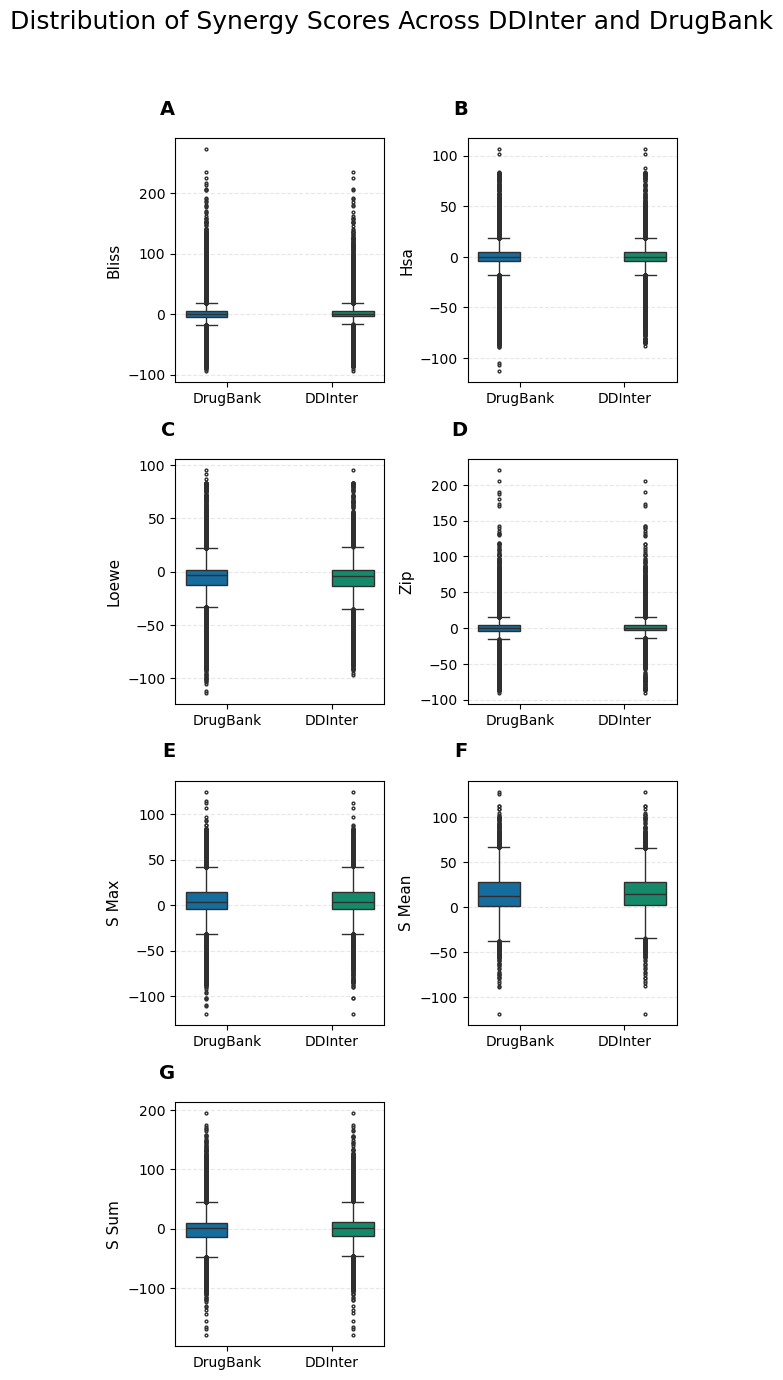

In [7]:
drugbank_df["Database"] = "DrugBank"
ddinter_df["Database"] = "DDInter"
drug_syntox_df = pd.concat([drugbank_df, ddinter_df], ignore_index=True)

# Assuming drug_syntox_df already loaded with 'Database' column
metrics = ['synergy_bliss', 'synergy_hsa', 'synergy_loewe',
           'synergy_zip', 'S_max', 'S_mean', 'S_sum']
palette = {'DrugBank': '#0072B2', 'DDInter': '#009E73'}

metrics_per_row = 2
rows = math.ceil(len(metrics) / metrics_per_row)
cols = metrics_per_row # Only one column needed per metric

fig, axes = plt.subplots(rows, cols, figsize=(6, 3.6 * rows), sharey=False)

# Reshape axes if only one row/column
if rows == 1 and cols == 1:
    axes = [[axes]]
elif rows == 1:
    axes = [axes]
elif cols == 1:
    axes = [[ax] for ax in axes]


panel_letters = list(string.ascii_uppercase)

def pretty_metric(name):
    return name.replace("synergy_", "").replace("_", " ").title()

# --- Combined Plotting Logic ---

for idx, metric in enumerate(metrics):
    r = idx // metrics_per_row
    c = idx % metrics_per_row
    ax = axes[r][c]
    pretty_name = pretty_metric(metric)

    # Use seaborn.boxplot with 'x' (or 'y' if rotated) for the metric and 'hue' for the database
    sns.boxplot(
        data=drug_syntox_df,
        y=metric,
        x='Database', # Use 'Database' on the x-axis to separate the box plots
        hue='Database', # Use 'Database' for color separation
        palette=palette,
        fliersize=2,
        ax=ax,
        dodge=True # Ensure the boxes for different hues are side-by-side
    )
    
    # Remove the automatic x-axis label as 'Database' is on the x-axis
    ax.set_xlabel('')
    # Set the y-axis label to the metric name
    ax.set_ylabel(pretty_name, fontsize=11)
    
    # Set the title to the metric name (optional, can be inferred from the y-label)
    # ax.set_title(pretty_name, fontsize=11, loc='center', pad=8)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    # Remove the legend since the x-axis labels are sufficient
    if ax.legend_:
        ax.legend_.remove()

    # ➤ Add panel letter above the plot
    letter = panel_letters[idx]
    ax.text(
        -0.0, 1.08,  # Adjusted to be above and slightly to the left of the subplot
        letter, transform=ax.transAxes,
        ha='right', va='bottom',
        fontsize=14, fontweight='bold'
    )

# Remove empty subplots if odd number of metrics
flat_axes = [item for sublist in axes for item in sublist]
for k in range(len(metrics), len(flat_axes)):
    fig.delaxes(flat_axes[k])

# Global labels
fig.suptitle('Distribution of Synergy Scores Across DDInter and DrugBank', fontsize=18, y=0.995)

plt.tight_layout(rect=[0.0, 0.04, 1, 0.97])
# fig.savefig('results/summary_stats_database/combined_synergy_panels_single_plot.png', dpi=300, bbox_inches='tight')
plt.show()
